In [19]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Bidirectional, Input, Dropout, Layer, Reshape, Masking, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, BinaryAccuracy, F1Score
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import difflib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report

import numpy as np
import re

from transformers import AutoTokenizer, TFAutoModel, AutoConfig, pipeline, WhisperFeatureExtractor, WhisperTokenizer, AutoModelForSpeechSeq2Seq, TFBertModel
from datasets import Dataset

from evaluate import load
from openai import OpenAI

import sounddevice as sd

import joblib
import pickle

In [2]:
from datasets import load_dataset

# load dataset from huggingface
ds = load_dataset("amaai-lab/DisfluencySpeech")

train = ds["train"]
val  = ds["validation"]
test = ds["test"]

In [3]:
# First approach - use a basic LSTM to predict filter words. For each word, assign 0 if removed between transcript a and transcript c, 1 if kept

class LSTMModel():
    # segmented - if true, have punctuation marks like , . ? as there own tokens
    # lower - lower case
    def __init__(self, segmented=True, lower=True, model_type="lstm"):

        # load in data 
        X_train = [x.lower().strip() for x in list(train["transcript_a"])] if lower else [x.strip() for x in list(train["transcript_a"])]
        y_train = [x.lower().strip() for x in list(train["transcript_c"])] if lower else [x.strip() for x in list(train["transcript_c"])]

        X_val = [x.lower().strip() for x in list(val["transcript_a"])] if lower else [x.strip() for x in list(val["transcript_a"])]
        y_val = [x.lower().strip() for x in list(val["transcript_c"])] if lower else [x.strip() for x in list(val["transcript_c"])]

        X_test = [x.lower().strip() for x in list(test["transcript_a"])] if lower else [x.strip() for x in list(test["transcript_a"])]
        y_test = [x.lower().strip() for x in list(test["transcript_c"])] if lower else [x.strip() for x in list(test["transcript_c"])]

        # pre_process if segmented 
        if segmented:
            X_train = [self.pre_process_text(x) for x in X_train]
            X_test = [self.pre_process_text(x) for x in X_test]
            X_val = [self.pre_process_text(x) for x in X_val]
            y_train = [self.pre_process_text(x) for x in y_train]
            y_test = [self.pre_process_text(x) for x in y_test]
            y_val = [self.pre_process_text(x) for x in y_val]

        # tokenizer does not include , . ? in the filters if segmented is true, then it filters everything else out
        self.tokenizer = Tokenizer(oov_token="oov", filters='"#$%&()*+-/<=>@[\\]^_`{|}~\t\n') if segmented else Tokenizer(oov_token="oov")
        self.tokenizer.fit_on_texts(X_train + y_train + X_val + y_val + X_test + y_test)
        self.vocab_size = len(self.tokenizer.word_index)+1 #+1 for oov

        # about 90% of the data is less than 40 words long
        self.max_length = 40

        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test

        self.segmented = segmented
        self.lower = True
        self.model_type = model_type


    # use re to add a space before notable punctuation
    def pre_process_text(self, text):
        text = re.sub(r'([,.?!:;])',r' \1',text)
        return text


    # function that takes in raw text and clean text; returns tokens of raw_text and a list of binary labels (1 for remove, 2 for keep)
    def make_binary_labels(self, raw, clean, return_tokens=True):
        raw_words = raw.split()
        clean_words = clean.split()
        
        matcher = difflib.SequenceMatcher(None, raw_words, clean_words) #isJunk = None to ignore no items
        labels = []

        for tag, i1, i2, j1, j2 in matcher.get_opcodes():
            if tag == 'equal':
                labels += [2] * (i2 - i1)   # keep
            else:
                labels += [1] * (i2 - i1)   # remove
        
        # for model 2, which uses different encodings
        if not return_tokens:
            return raw_words, labels

        return self.tokenizer.texts_to_sequences([raw])[0], labels
    

    # prints a histogram of the number of words per sequence
    def plot_seq_lengths(self):
        X_train_lengths = [len(i.split()) for i in self.X_train]
        print(f"First few lengths: {X_train_lengths[:5]}")

        plt.hist(X_train_lengths)
        plt.plot()


    # take in all raw/clean data and reformat as raw_tokens/clean labels after padding
    def encode_example(self, x, y):
        raw_token, raw_label = self.make_binary_labels(x, y)

        # pad sequences to each be the same length
        tokens_padded = pad_sequences([raw_token], maxlen=self.max_length, padding='post')[0]
        labels_padded = pad_sequences([raw_label], maxlen=self.max_length, padding='post')[0]

        return tokens_padded, labels_padded
    

    # create a binary dataset from raw->clean dataset
    def create_binary_dataset(self,X,Y):
        x_toks = []
        y_labels = []

        for x,y in zip(X,Y):
            toks, labels = self.encode_example(x,y)
            x_toks.append(toks)
            y_labels.append(labels)
        
        return np.array(x_toks), np.array(y_labels)

    
    # print the proportions of each label to check if padding makes sense 
    def print_props(self, y_labels):
        unique, counts = np.unique(y_labels,return_counts=True)
        for u, c in zip(unique, counts):
            print(f"Percentage {u} is {c / counts.sum()}")

    
    # train the model
    def train(self,epochs):
        self.X_train_tokens, self.y_train_labels = self.create_binary_dataset(self.X_train, self.y_train)
        self.X_val_tokens, self.y_val_labels = self.create_binary_dataset(self.X_val, self.y_val)
        self.X_test_tokens, self.y_test_labels = self.create_binary_dataset(self.X_test, self.y_test)
        
        self.model = Sequential([
            Embedding(input_dim=self.vocab_size, input_shape=(self.vocab_size,), output_dim=32, mask_zero=True), # masks zero so we can use sparsecategoricalcrossentropy and accuracy without the padding affecting the loss
            Bidirectional(LSTM(units=100, dropout=0.2, return_sequences=True)),
            Bidirectional(LSTM(units=50, dropout=0.2, return_sequences=True)),
            Dense(3, activation='softmax') # pad, keep, remove
        ])
        self.model.summary()

        # add sample weights to emphasize getting the removed tokens right more frequently
        sample_weights = np.ones_like(self.y_train_labels) # same shape, all ones
        sample_weights[self.y_train_labels==0] = 0 # this also makes the padded words not count in the accuracy calculation
        sample_weights[self.y_train_labels==1] = 2
        sample_weights[self.y_train_labels==2] = 1

        self.model.compile(
            optimizer= Adam(0.001), # learning rate
            loss= SparseCategoricalCrossentropy(),
            metrics=[SparseCategoricalAccuracy()])

        callbacks = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=4, restore_best_weights=True) # implement early stopping to prevent overfitting
        history = self.model.fit(self.X_train_tokens,
                self.y_train_labels,
                epochs=epochs,
                validation_data=(self.X_val_tokens, self.y_val_labels),
                sample_weight=sample_weights,
                callbacks=callbacks)
        
        # plot loss and accuracy over epochs
        plt.plot(history.history['sparse_categorical_accuracy'], label = 'accuracy')
        plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')

        plt.xlabel('Epoch')
        plt.legend()

        plt.plot()


    # predict a raw text input, returning the predicted labels, the sentnece, and the tokenized sequence
    def predict_sequence(self,raw_text):
        # tokenize and pad
        seq = self.tokenizer.texts_to_sequences([self.pre_process_text(raw_text)] if self.segmented else [raw_text])
        seq = pad_sequences(seq, maxlen=self.max_length, padding='post')

        # predict sequence
        preds = self.model.predict(seq)[0]
        pred_classes = np.argmax(preds, axis=-1)

        # reverse word_index to get words from tokens
        reverse_index = {v: k for k, v in self.tokenizer.word_index.items()}
        reverse_index[0] = '<PAD>'

        # only keep words labelled 2
        pred_sentence = ''
        for idx, label in zip(seq[0],pred_classes):
            if idx == 0: #ignore padding
                continue 

            if label == 2: # only keep 2s
                word = reverse_index[idx]
                pred_sentence += word + ' '

        # put sentence back together
        pred_sentence = re.sub(r' ([,.?!:;])',r'\1',pred_sentence)

        return pred_classes, pred_sentence, seq


    # print a confusion matrix given tokens and labels
    def print_cm(self,toks,labels):  
        predictions = self.model.predict(toks)
        y_pred = np.argmax(predictions, axis=-1).flatten()
        y_gold = labels.flatten()

        # remove padding values 
        mask = (y_gold != 0)
        y_pred = y_pred[mask]
        y_gold = y_gold[mask]

        cm = confusion_matrix(y_gold, y_pred, labels=[1,2])

        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()

        labels = ['Remove', 'Keep']

        disp.ax_.set_title("Filter Model")
        disp.ax_.set_xticklabels(labels,rotation=90)
        disp.ax_.set_yticklabels(labels)

        # use sklearn metrics 
        print(f"F1 score: {f1_score(y_gold, y_pred)}")
        print(f"Classification Report: \n {classification_report(y_gold, y_pred)}")

        plt.show()


    # evaluate on test data, predict a given sentence, and print the cm
    def show_eval(self):
        loss, accuracy = self.model.evaluate(self.X_test_tokens, self.y_test_labels)

        print(f"Test loss: {loss}")
        print(f"Test accuracy: {accuracy}")

        print("\n-------------\n")

        print("Testing on the sentence: i, uh, don't, i don't think that is true")
        print("Expected: i don't think that is true")
        print(f"Result: {self.predict_sequence("i, uh, don't, i don't think that is true")[1]}")

        self.print_cm(self.X_test_tokens,self.y_test_labels)

        
    # train an evaluate
    def run(self, epochs):
        self.train(epochs)
        self.show_eval()

In [4]:
# need this wrapper class to avoid getting errors, bert takes in only tensorflow tensors and not keras tensors
class BertLayer(Layer):
    def __init__(self, model):
        super().__init__() # init Layer class
        self.config = AutoConfig.from_pretrained(model, output_hidden_states=True)
        self.bert = TFBertModel.from_pretrained( #bert model
            model,
            config=self.config,
            from_pt=True
        )

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        hidden_states = outputs.hidden_states
        layers = hidden_states[-4:] # get last 4 hidden layers
        x = tf.concat(layers, axis=-1)
        return x

    def compute_output_shape(self, input_shape):
        batch = input_shape[0][0]
        seq = input_shape[0][1]
        return (batch, seq, self.config.hidden_size * 4)


# Transformer model, inherited from bart
class TransformerModel(LSTMModel):
    def __init__(self, batch=8, segmented=True, lower=True, model_type="transformer"):
        super().__init__(segmented, lower, model_type) # init from parent class

        # different tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.batch = batch
    

    # when assigning labels, BERT will separate words like testing into test and ing. Use word_ids here to ensure that each subword has the same class as other subwords
    def subword_segment(self, word_ids, y_labels):
        labels = []

        for i in word_ids:
            if i is None:
                labels.append(0) # label special characters the same as padding
            else:
                labels.append(y_labels[i])
        
        return labels
    

    # take in clean and raw text, and return an encoding dictionary of tensors that includes tokens ('input_ids'), labels ('labels'), and attention_mask (used during training, 1 for use a word, 0 for not (special character, padding, etc.))
    def encode_example(self, X, y):
        X_raw_words, y_labels = self.make_binary_labels(X,y,return_tokens=False) #return raw words instead
        
        encoding = self.tokenizer.encode_plus(X_raw_words, 
                                        max_length=self.max_length, #est earlier
                                        truncation=True, 
                                        padding="max_length",
                                        is_split_into_words=True,
                                        return_token_type_ids=False, #don't need these
                                        return_tensors='tf' #for tensorflow
                                        )
        
        #create labels to give subwords the same class using word ids
        word_ids = encoding.word_ids()
        labels = self.subword_segment(word_ids, y_labels)
        
        encoding["labels"] = labels
        encoding["input_ids"] = encoding["input_ids"][0]
        encoding["attention_mask"] = encoding["attention_mask"][0]
        return encoding
        
    
    # training method    
    def train(self, epochs):
        train_encodings = [self.encode_example(x,y) for x,y in zip(self.X_train, self.y_train)]
        test_encodings = [self.encode_example(x,y) for x,y in zip(self.X_test, self.y_test)]
        val_encodings = [self.encode_example(x,y) for x,y in zip(self.X_val, self.y_val)]

        self.train_ds = Dataset.from_list(train_encodings)
        self.test_ds = Dataset.from_list(test_encodings)
        self.val_ds = Dataset.from_list(val_encodings)

        # use tokens and attention mask as the inputs
        input_ids = Input(shape=(self.max_length,), name="input_ids", dtype=tf.int32)
        attention_mask = Input(shape=(self.max_length,), name="attention_mask", dtype=tf.int32)

        # return the final 4 hidden layers from Bert, using uncased or cased to match with training data
        sequence_outputs = BertLayer(model="bert-base-uncased" if self.lower else "bert-base-cased") ((input_ids, attention_mask))

        x = Dropout(0.3)(sequence_outputs)
        x = TimeDistributed(Dense(256, activation='relu'))(x) # time distributed due to attention
        x = Dropout(0.3)(x)
        #x = TimeDistributed(Dense(64, activation='relu'))(x)
        #x = Dropout(0.2)(x)
        y = TimeDistributed(Dense(3, activation='softmax'))(x) #output

        self.model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)
        self.model.summary()

        # sample weights
        sample_weights = np.ones_like(self.train_ds["labels"]) 
        sample_weights[self.train_ds["labels"]==0] = 0
        sample_weights[self.train_ds["labels"]==1] = 3
        sample_weights[self.train_ds["labels"]==2] = 1

        # train the model
        self.model.compile(
            optimizer= Adam(3e-5), # learning rate
            loss= SparseCategoricalCrossentropy(),
            metrics= [SparseCategoricalAccuracy()])


        self.train_tf = tf.data.Dataset.from_tensor_slices((
            {
                "input_ids": np.array(self.train_ds["input_ids"], dtype=np.int32),
                "attention_mask": np.array(self.train_ds["attention_mask"], dtype=np.int32)
            },
            np.array(self.train_ds["labels"]),
            sample_weights.astype(np.float32))) #sample_weights added here

        self.val_tf = tf.data.Dataset.from_tensor_slices((
            {
                "input_ids": np.array(self.val_ds["input_ids"], dtype=np.int32),
                "attention_mask": np.array(self.val_ds["attention_mask"], dtype=np.int32)
            },
            np.array(self.val_ds["labels"])))

        callbacks = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=3, restore_best_weights=True) # implement early stopping to prevent overfitting
        history = self.model.fit(self.train_tf.batch(self.batch), 
                            epochs=epochs, 
                            validation_data=self.val_tf.batch(self.batch),
                            callbacks=callbacks
                            )

        # plot loss and accuracy over epochs
        plt.plot(history.history['sparse_categorical_accuracy'], label = 'accuracy')
        plt.plot(history.history['loss'], label = 'loss')
        plt.plot(history.history['val_sparse_categorical_accuracy'], label = 'val_accuracy')
        plt.plot(history.history['val_loss'], label = 'val_loss')

        plt.xlabel('Epoch')
        plt.legend()

        plt.plot()


    # predict a raw text input
    def predict_sequence(self,raw_text):
        # tokenize and pad
        encoding = self.tokenizer.encode_plus(raw_text.split(), 
                                        max_length=self.max_length, #est earlier
                                        truncation=True, 
                                        padding="max_length",
                                        is_split_into_words=True,
                                        return_token_type_ids=False, #don't need these
                                        return_tensors='tf' #for tensorflow
                                        )

        # predict sequence
        preds = self.model.predict({"input_ids": encoding["input_ids"],
                            "attention_mask": encoding["attention_mask"]})
        
        pred_classes = np.argmax(preds, axis=-1)[0]
        
        tokens = self.tokenizer.convert_ids_to_tokens(encoding["input_ids"][0])
        word_ids = encoding.word_ids(batch_index=0)

        pred_words = []
        current_word_tokens = [] # keep track of current word vs word_id for the sake of subwords
        current_word_id = None
        for tok, label, wid in zip(tokens,pred_classes,word_ids):
            if wid is None: # for special tags
                continue

            if wid != current_word_id: # new word
                if current_word_id is not None and first_label == 2:
                    pred_words.append("".join(current_word_tokens))

                current_word_id = wid
                current_word_tokens = [tok.replace("##", "")]
                first_label = label
                
            else: # for subwords
                current_word_tokens.append(tok.replace("##",""))
            
        if current_word_id is not None and first_label == 2:
            pred_words.append("".join(current_word_tokens))

        # put sentence back together
        pred_sentence = " ".join(pred_words)
        pred_sentence = re.sub(r' ([,.?!:;])',r'\1',pred_sentence)
        pred_sentence = re.sub(r" ' ", r"'", pred_sentence)
        
        return pred_classes, pred_sentence, encoding

    # print the confusion matrix 
    def print_cm(self, tens):
        predictions = self.model.predict(tens.batch(self.batch))
        y_pred = np.argmax(predictions, axis=-1).flatten()

        # get gold values across batches and flatten
        y_list = []
        for batch in tens:
            _, y_batch = batch   
            y_list.append(y_batch.numpy()) 
        y = np.concatenate(y_list, axis=0) 

        # mask padded labels
        mask = (y != 0)
        y_pred = y_pred[mask]
        y = y[mask]

        cm = confusion_matrix(y, y_pred, labels=[1,2])

        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()

        labels = ['Remove', 'Keep']

        disp.ax_.set_title("Filter Model")
        disp.ax_.set_xticklabels(labels,rotation=90)
        disp.ax_.set_yticklabels(labels)

        # use sklearn metrics 
        print(f"F1 score: {f1_score(y, y_pred)}")
        print(f"Classification Report: \n {classification_report(y, y_pred)}")

        plt.show()


    # evaluate, test on example, and print confusion matrix
    def show_eval(self):
        test_tf = tf.data.Dataset.from_tensor_slices((
            {
                "input_ids": np.array(self.test_ds["input_ids"], dtype=np.int32),
                "attention_mask": np.array(self.test_ds["attention_mask"], dtype=np.int32)
            },
            np.array(self.test_ds["labels"])
        ))

        loss, accuracy = self.model.evaluate(test_tf.batch(self.batch))

        print(f"Test loss: {loss}")
        print(f"Test accuracy: {accuracy}")

        print("\n-------------\n")

        print("Testing on the sentence: i, uh, don't, i don't think that is true")
        print("Expected: i don't think that is true")
        print(f"Result: {self.predict_sequence("i, uh, don't, i don't think that is true")[1]}")

        self.print_cm(test_tf)


        

In [ ]:
# class putting together Emil's speech to text model and one of the above models, adding in llm calls as well
class STOT():
    def __init__(self,model,API,audio_predictions=[]):
        self.model = model

        self.client = OpenAI(
            base_url="https://openrouter.ai/api/v1",
            api_key=API,
            )

        self.word_error = load("wer")
        self.asr = pipeline(task="automatic-speech-recognition",
            tokenizer=WhisperTokenizer.from_pretrained("Model"),
            model=AutoModelForSpeechSeq2Seq.from_pretrained("Model"),
            feature_extractor=WhisperFeatureExtractor())

        self.lower = self.model.lower
        self.segmented = self.model.segmented
        self.audio_predictions=audio_predictions
        

    # takes in audio data and returns the transcribed text
    def transcribe(self, audio):
        transcription = self.asr(audio)["text"].lower() if self.lower else self.asr(audio)["text"]
        return self.model.pre_process_text(transcription) if self.model.segmented else transcription


    # get more academic sentence
    def call_api(self, text):
        content = "Give me a more academic way of saying the following sentence. Only return the relevant sentence and nothing else: \n" + text
        # API Call
        response = self.client.chat.completions.create(
            model="openai/gpt-oss-20b:free",
            messages=[{
                    "role": "user",
                    "content": content}
                ]
        )
        
        response = response.choices[0].message.content
        #print(f"New Sentence: {response}")
        return response


    # eval a single audio input
    def eval_single_input(self, num):
        audio = list(test["audio"])[num]
        unfiltered_transcript = self.model.X_test[num]
        filtered_transcript = self.model.y_test[num]

        transcribed_audio = self.transcribe(audio)
        print(f"Audio Transcription: {transcribed_audio}")
        print(f"True Transcription: {unfiltered_transcript}")
        print(f"Word Error Rate: {self.word_error.compute(predictions=transcribed_audio, references=unfiltered_transcript)}")
        print("-------------------")

        classes_from_model, transcript_from_model, mod_enc = self.model.predict_sequence(transcribed_audio)
        classes_from_data, transcript_from_data, data_enc = self.model.predict_sequence(unfiltered_transcript)

        print(f"Transcription After Filter: {transcript_from_model}")
        print(f"Filtered Gold Text: {transcript_from_data}")
        print(f"True Filter: {filtered_transcript}")

        # get true labels
        if self.model.model_type == "transformer":
            true_enc_mod = self.model.encode_example(transcribed_audio, filtered_transcript)
            true_labels_mod = true_enc_mod["labels"]
            true_enc_data = self.model.encode_example(unfiltered_transcript, filtered_transcript)
            true_labels_data = true_enc_data["labels"]
        else:
            _, true_labels_mod = self.model.encode_example(transcribed_audio, filtered_transcript)
            _, true_labels_data = self.model.encode_example(unfiltered_transcript, filtered_transcript)

        # mask 0s
        mask_model = (true_labels_mod != 0)
        classes_from_model = classes_from_model[mask_model]
        true_labels_mod = true_labels_mod[mask_model]

        mask_data = (true_labels_data != 0)
        classes_from_data = classes_from_data[mask_data]
        true_labels_data = true_labels_data[mask_data]

        # print accuracies
        accuracy_mod = np.mean(classes_from_model == true_labels_mod)
        print(f"Total Model Accuracy: {accuracy_mod}, F1: {f1_score(classes_from_model,true_labels_mod)}")

        accuracy_dat = np.mean(classes_from_data == true_labels_data)
        print(f"Filter Model Accuracy: {accuracy_dat}, F1: {f1_score(classes_from_data,true_labels_data)}")

        # prompt the LLM to get a more academic response
        #self.call_api(transcript_from_model)
        

    # eval entire dataset
    def eval(self):
        # get data
        audio_data = list(test["audio"])
        intermediary_data = self.model.X_test
        final_data = self.model.y_test

        # transcribe audio if not already transcribed
        if len(self.audio_predictions) == 0:
            for i in range(len(audio_data)):
                audio_pred = self.transcribe(audio_data[i])
                self.audio_predictions.append(audio_pred)

        # get word error rate
        average_wer = self.word_error.compute(predictions=self.audio_predictions, references=intermediary_data)
        print(f"Average Word Error Rate of Stot Model: {average_wer}")
        
        # measure accuracy of filter
        if self.model.model_type == "transformer":
            encoding = [self.model.encode_example(raw, clean) for raw, clean in zip(self.audio_predictions, final_data)]
            enc_ds = Dataset.from_list(encoding)

            enc_tf = tf.data.Dataset.from_tensor_slices((
                {
                    "input_ids": np.array(enc_ds["input_ids"], dtype=np.int32),
                    "attention_mask": np.array(enc_ds["attention_mask"], dtype=np.int32)
                },
                np.array(enc_ds["labels"]),
            ))

            loss, accuracy = self.model.model.evaluate(enc_tf.batch(self.model.batch))

            self.model.print_cm(enc_tf)

        else:
            filter_input, filter_output = self.model.create_binary_dataset(self.audio_predictions, final_data)
            loss, accuracy = self.model.model.evaluate(filter_input, filter_output)

            self.model.print_cm(filter_input, filter_output)

        print(f"Final Accuracy: {accuracy}, Final Loss: {loss}")

        
    # record audio and run through model
    def input_audio(self,duration=5,sample_rate=16000):
        print("Recording...")
        audio = sd.rec(int(duration*sample_rate), samplerate=sample_rate, channels=1)
        sd.wait()
        print("Stopped")

        audio = audio.squeeze()  # remove channel dimension

        transcribed_audio = self.transcribe({
            "array": audio,
            "sampling_rate": sample_rate,
        })

        _, transcript_from_model, _ = self.model.predict_sequence(transcribed_audio)

        print(transcript_from_model)

        self.api_call(transcript_from_model)

    
    def run(self, audio):
        transcribed_audio = self.transcribe(audio)
        filtered_text = self.model.predict_sequence(transcribed_audio)[1]
        response = self.call_api(filtered_text)

        transcribed_audio = re.sub(r' ([,.?!:;])',r'\1',transcribed_audio)
        transcribed_audio = re.sub(r" ' ", r"'", transcribed_audio)
        
        return transcribed_audio, response

/Users/jorgemy/Desktop/School/schoool/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 6517, 32)       │       208,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 6517, 200)      │       106,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 6517, 100)      │       100,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6517, 3)        │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,647 (1.59 MB)

 Trainable params: 415,647 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.5203 - sparse_categorical_accuracy: 0.8535 - val_loss: 0.2764 - val_sparse_categorical_accuracy: 0.8849
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 0.3286 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.2541 - val_sparse_categorical_accuracy: 0.8979
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.3042 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.2601 - val_sparse_categorical_accuracy: 0.8945
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.2806 - sparse_categorical_accuracy: 0.9116 - val_loss: 0.2810 - val_sparse_categorical_accuracy: 0.8781
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.2636 - sparse_categorical_accuracy: 0.9172 - val_loss: 0.2490 - val_sparse_categorical_accuracy: 0.9015
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.2480 - sparse_categorical_accuracy: 0.9222 - val_loss: 0.2430 - val_sparse_categorical_accuracy: 0.90

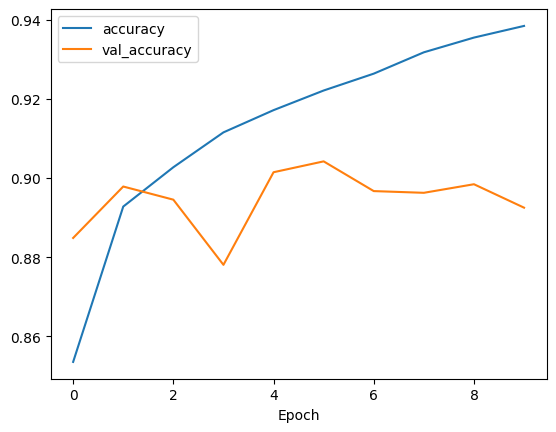

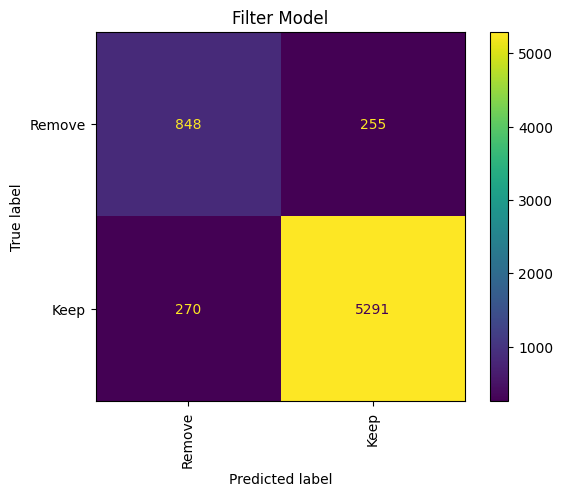

In [6]:
mod1 = LSTMModel() 
mod1.run(20)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Al

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 40, 3072)  │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 40, 3072)  │          0 │ bert_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 40, 256)   │    786,688 │ dropout[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 40, 256)   │          0 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 40, 3)     │        771 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 787,459 (3.00 MB)

 Trainable params: 787,459 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 155s 264ms/step - loss: 0.2705 - sparse_categorical_accuracy: 0.9001 - val_loss: 0.1672 - val_sparse_categorical_accuracy: 0.9372
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 149s 264ms/step - loss: 0.1675 - sparse_categorical_accuracy: 0.9357 - val_loss: 0.1540 - val_sparse_categorical_accuracy: 0.9413
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 160s 284ms/step - loss: 0.1529 - sparse_categorical_accuracy: 0.9392 - val_loss: 0.1473 - val_sparse_categorical_accuracy: 0.9424
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 161s 285ms/step - loss: 0.1444 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.1434 - val_sparse_categorical_accuracy: 0.9438
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 164s 291ms/step - loss: 0.1385 - sparse_categorical_accuracy: 0.9429 - val_loss: 0.1402 - val_sparse_categorical_accuracy: 0.9447
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 166s 296ms/step - loss: 0.1340 - sparse_categorical_accuracy: 0.9444 - val_loss: 0.1381 - val_sparse_categoric

2025-12-01 10:29:42.348080: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report: 
               precision    recall  f1-score   support

           1       0.84      0.77      0.81      1156
           2       0.96      0.97      0.96      6060

    accuracy                           0.94      7216
   macro avg       0.90      0.87      0.89      7216
weighted avg       0.94      0.94      0.94      7216



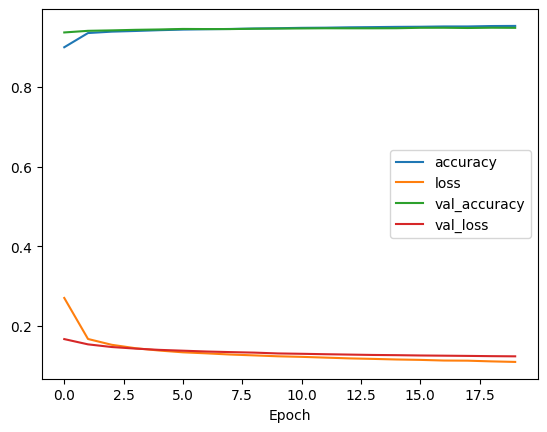

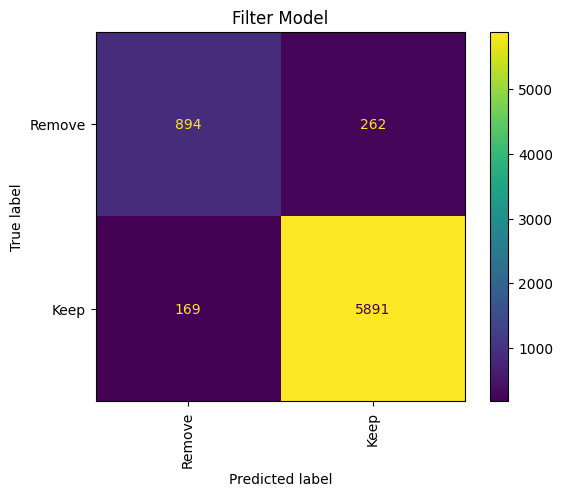

In [7]:
mod2 = TransformerModel(batch=8)
mod2.run(20)

In [ ]:
# can load in and pass to multiple models

word_error = load("wer")
asr = pipeline(task="automatic-speech-recognition",
    tokenizer=WhisperTokenizer.from_pretrained("Model"),
    model=AutoModelForSpeechSeq2Seq.from_pretrained("Model"),
    feature_extractor=WhisperFeatureExtractor())

def transcribe(audio,lower=True,segmented=True):
    transcription = asr(audio)["text"].lower() if lower else asr(audio)["text"]
    return mod1.pre_process_text(transcription) if segmented else segmented

audio_data = list(test["audio"])
intermediary_data = [x.lower() for x in list(test["transcript_a"])]

audio_predictions = []
for i in range(len(audio_data)):
    audio_pred = transcribe(audio_data[i])
    audio_predictions.append(audio_pred)

average_wer = word_error.compute(predictions=audio_predictions, references=intermediary_data)

In [ ]:
APIKey = # insert key here 
stot = STOT(model=mod2, API=APIKey)

Device set to use mps:0


In [13]:
stot.run(list(train["audio"])[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


("yeah, i do. yes, uh, i don't work, though, but i used to work and, when i had two children.",
 'I am, indeed, presently unemployed, although I was previously employed during the period when I had two children.')

In [ ]:
#mod2.model.save('model2.keras')